[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/intel-analytics/BigDL/blob/main/python/nano/notebooks/hpo/seq_and_func.ipynb)

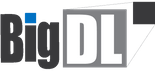

# Introduction
In this notebook we demonstrates how to use Nano HPO to tune the hyperparameters in tensorflow training. The model is built using either tensorflow keras sequential API or functional API.


# Step0: Prepare Environment
You can install the latest pre-release version with nano support using below commands.

We recommend to run below commands, especially `source bigdl-nano-init` before jupyter kernel is started, or some of the optimizations may not take effect.


In [ ]:
# Install latest pre-release version of bigdl-nano
!pip install --pre bigdl-nano[tensorflow]
!pip install setuptools==58.0.4
!pip install protobuf==3.20.1
!source bigdl-nano-init

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
conda dir found: /usr/local/bin/..
OpenMP library found...
Setting OMP_NUM_THREADS...
Setting OMP_NUM_THREADS specified for pytorch...
Setting KMP_AFFINITY...
Setting KMP_BLOCKTIME...
Setting MALLOC_CONF...
Not in a conda env
+++++ Env Variables +++++
LD_PRELOAD=/usr/lib/x86_64-linux-gnu/libtcmalloc.so.4
MALLOC_CONF=
OMP_NUM_THREADS=1
KMP_AFFINITY=granularity=fine,compact,1,0
KMP_BLOCKTIME=1
TF_ENABLE_ONEDNN_OPTS=1
ENABLE_TF_OPTS=1
NANO_TF_INTER_OP=1
+++++++++++++++++++++++++
Complete.


In [ ]:
# Install other dependecies for Nano HPO
!pip install ConfigSpace
!pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.7 MB 7.4 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 308 kB 7.7 MB/s 
     |████████████████████████████████| 209 kB 55.4 MB/s 
     |████████████████████████████████| 81 kB 8.0 MB/s 
     |████████████████████████████████| 78 kB 5.9 MB/s 
     |████████████████████████████████| 112 kB 49.2 MB/s 
     |████████████████████████████████| 49 kB 5.7 MB/s 
     |████████████████████████████████| 146 kB 49.9 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11137 sha256=50f3f2456ea704b7882c94a258550d46ac88cc02884fdeaf4c92e4b400ce35c1
  Stored in directory: /root/.cache/pip/wheels/9f/18/84/8f69f8b08169c7bae2dde6bd7daf0c19fca8c8e500ee620a28
Successfully built pyperclip


# Step1: Init Nano AutoML
We need to enable Nano HPO before we use it for tensorflow training.

In [ ]:
import bigdl.nano.automl as automl
automl.hpo_config.enable_hpo_tf()

/usr/local/lib/python3.7/dist-packages/bigdl/nano/tf/__init__.py:24: UserWarning: NANO_TF_INTER_OP not found the in os.environ, please run `source bigdl-nano-init`
  warnings.warn("NANO_TF_INTER_OP not found the in os.environ, "
/usr/local/lib/python3.7/dist-packages/bigdl/nano/tf/__init__.py:30: UserWarning: OMP_NUM_THREADS not found the in os.environ, please run `source bigdl-nano-init`
  warnings.warn("OMP_NUM_THREADS not found the in os.environ, "


# Step2: Prepare data
We use MNIST dataset for demonstration.

In [ ]:
from tensorflow import keras

(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

CLASSES = 10
img_x, img_y = x_train.shape[1], x_train.shape[2]
input_shape = (img_x, img_y, 1)
x_train = x_train.reshape(-1, img_x, img_y,1).astype("float32") / 255
x_test = x_test.reshape(-1, img_x, img_y,1).astype("float32") / 255

11501568/11490434 [==============================] - 0s 0us/step


# Step3: Build model and specify search spaces

We now create our model. 

Change the imports from tensorflow.keras to bigdl.nano as below, and you will be able to specify search spaces as you define the model. For how to specify search space, refer to [user doc](https://bigdl.readthedocs.io/en/latest/doc/Nano/QuickStart/hpo.html).

In [ ]:
from bigdl.nano.automl.tf.keras import Sequential
from bigdl.nano.tf.keras.layers import Dense, Flatten, Conv2D
from bigdl.nano.tf.keras import Input
from bigdl.nano.automl.tf.keras import Model
import bigdl.nano.automl.hpo.space as space

Below two cells show how to define the model with search spaces using either sequential or functional API respectively. You can choose one of them to run.

In [ ]:
model = Sequential()
model.add(Conv2D(
    filters=space.Categorical(32, 64),
    kernel_size=space.Categorical(3, 5),
    strides=space.Categorical(1, 2),
    activation=space.Categorical("relu", "linear"),
    input_shape=input_shape))
model.add(Flatten())
model.add(Dense(CLASSES, activation="softmax"))

In [ ]:
inputs = Input(shape=(28,28,1))
x = Conv2D(
    filters=space.Categorical(32, 64),
    kernel_size=space.Categorical(3, 5),
    strides=space.Categorical(1, 2),
    activation=space.Categorical("relu", "linear"),
    input_shape=input_shape)(inputs)
x = Flatten()(x)
outputs = Dense(CLASSES, activation="softmax")(x)
model = Model(inputs=inputs, outputs=outputs, name="mnist_model")

# Step4: Compile model
We now compile our model with loss function, optimizer and metrics. If you want to tune learning rate and batch size, refer to [user guide](https://bigdl.readthedocs.io/en/latest/doc/Nano/QuickStart/hpo.html#search-the-learning-rate).

In [ ]:
from tensorflow.keras.optimizers import RMSprop
model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=RMSprop(learning_rate=0.001),
    metrics=["accuracy"]
)

# Step5: Run hyperparameter search
Run hyperparameter search by calling `model.search`. Set `n_trials` to the number of trialials you want to run, and set the `target_metric` and `direction` so that HPO optimizes the `target_metric` in the specified `direction`. Each trial will use a different set of hyperparameters in the search space range. After search completes, you can use `search_summary` to retrive the search results for analysis. For more details, refer to [user doc](https://bigdl.readthedocs.io/en/latest/doc/Nano/QuickStart/hpo.html)

In [ ]:
%%time
from bigdl.nano.automl.hpo.backend import PrunerType
model.search(
    n_trials=8,
    target_metric='val_accuracy',
    direction="maximize",
    pruner=PrunerType.HyperBand,
    pruner_kwargs={'min_resource':1, 'max_resource':100, 'reduction_factor':3},
    x=x_train,
    y=y_train,
    batch_size=128,
    epochs=5,
    validation_split=0.2,
    verbose=False
)

[I 2022-06-10 07:06:31,890] A new study created in memory with name: no-name-b1869d33-f7ad-404a-b5a8-734c0784052c


Starting a new tuning
Epoch 1/5
375/375 - 3s - loss: 0.4179 - accuracy: 0.8872 - val_loss: 0.2395 - val_accuracy: 0.9335 - 3s/epoch - 9ms/step
Epoch 2/5
375/375 - 3s - loss: 0.2149 - accuracy: 0.9376 - val_loss: 0.1784 - val_accuracy: 0.9524 - 3s/epoch - 9ms/step
Epoch 3/5
375/375 - 3s - loss: 0.1523 - accuracy: 0.9570 - val_loss: 0.1315 - val_accuracy: 0.9670 - 3s/epoch - 7ms/step
Epoch 4/5
375/375 - 3s - loss: 0.1167 - accuracy: 0.9669 - val_loss: 0.1095 - val_accuracy: 0.9720 - 3s/epoch - 9ms/step
Epoch 5/5
375/375 - 3s - loss: 0.0957 - accuracy: 0.9724 - val_loss: 0.0992 - val_accuracy: 0.9730 - 3s/epoch - 7ms/step


[I 2022-06-10 07:06:47,295] Trial 0 finished with value: 0.9729999899864197 and parameters: {'activation▁choice': 0, 'filters▁choice': 0, 'kernel_size▁choice': 0, 'strides▁choice': 1}. Best is trial 0 with value: 0.9729999899864197.


Epoch 1/5
375/375 - 9s - loss: 0.3837 - accuracy: 0.8881 - val_loss: 0.3021 - val_accuracy: 0.9144 - 9s/epoch - 24ms/step
Epoch 2/5
375/375 - 7s - loss: 0.3129 - accuracy: 0.9114 - val_loss: 0.2998 - val_accuracy: 0.9165 - 7s/epoch - 19ms/step
Epoch 3/5
375/375 - 8s - loss: 0.2973 - accuracy: 0.9162 - val_loss: 0.2974 - val_accuracy: 0.9142 - 8s/epoch - 22ms/step
Epoch 4/5
375/375 - 9s - loss: 0.2888 - accuracy: 0.9177 - val_loss: 0.2929 - val_accuracy: 0.9197 - 9s/epoch - 24ms/step
Epoch 5/5
375/375 - 8s - loss: 0.2822 - accuracy: 0.9218 - val_loss: 0.2906 - val_accuracy: 0.9210 - 8s/epoch - 20ms/step


[I 2022-06-10 07:07:28,702] Trial 1 finished with value: 0.9210000038146973 and parameters: {'activation▁choice': 1, 'filters▁choice': 0, 'kernel_size▁choice': 1, 'strides▁choice': 0}. Best is trial 0 with value: 0.9729999899864197.


Epoch 1/5
375/375 - 9s - loss: 0.3831 - accuracy: 0.8902 - val_loss: 0.3052 - val_accuracy: 0.9143 - 9s/epoch - 23ms/step
Epoch 2/5
375/375 - 8s - loss: 0.3129 - accuracy: 0.9112 - val_loss: 0.2855 - val_accuracy: 0.9205 - 8s/epoch - 22ms/step
Epoch 3/5
375/375 - 8s - loss: 0.2978 - accuracy: 0.9164 - val_loss: 0.2807 - val_accuracy: 0.9240 - 8s/epoch - 22ms/step
Epoch 4/5
375/375 - 8s - loss: 0.2881 - accuracy: 0.9190 - val_loss: 0.2823 - val_accuracy: 0.9225 - 8s/epoch - 22ms/step
Epoch 5/5
375/375 - 9s - loss: 0.2827 - accuracy: 0.9199 - val_loss: 0.2884 - val_accuracy: 0.9216 - 9s/epoch - 23ms/step


[I 2022-06-10 07:08:10,866] Trial 2 finished with value: 0.9240000247955322 and parameters: {'activation▁choice': 1, 'filters▁choice': 0, 'kernel_size▁choice': 1, 'strides▁choice': 0}. Best is trial 0 with value: 0.9729999899864197.


Epoch 1/5
375/375 - 3s - loss: 0.3833 - accuracy: 0.8935 - val_loss: 0.2027 - val_accuracy: 0.9457 - 3s/epoch - 9ms/step
Epoch 2/5
375/375 - 3s - loss: 0.1661 - accuracy: 0.9529 - val_loss: 0.1239 - val_accuracy: 0.9661 - 3s/epoch - 8ms/step
Epoch 3/5
375/375 - 4s - loss: 0.1056 - accuracy: 0.9697 - val_loss: 0.0900 - val_accuracy: 0.9750 - 4s/epoch - 10ms/step
Epoch 4/5
375/375 - 3s - loss: 0.0806 - accuracy: 0.9769 - val_loss: 0.0808 - val_accuracy: 0.9773 - 3s/epoch - 9ms/step
Epoch 5/5
375/375 - 3s - loss: 0.0663 - accuracy: 0.9807 - val_loss: 0.0728 - val_accuracy: 0.9793 - 3s/epoch - 8ms/step


[I 2022-06-10 07:08:27,356] Trial 3 finished with value: 0.9792500138282776 and parameters: {'activation▁choice': 0, 'filters▁choice': 0, 'kernel_size▁choice': 1, 'strides▁choice': 1}. Best is trial 3 with value: 0.9792500138282776.


Epoch 1/5
375/375 - 3s - loss: 0.4181 - accuracy: 0.8856 - val_loss: 0.2939 - val_accuracy: 0.9190 - 3s/epoch - 7ms/step
Epoch 2/5
375/375 - 2s - loss: 0.3041 - accuracy: 0.9133 - val_loss: 0.2788 - val_accuracy: 0.9234 - 2s/epoch - 6ms/step
Epoch 3/5
375/375 - 3s - loss: 0.2919 - accuracy: 0.9182 - val_loss: 0.2723 - val_accuracy: 0.9254 - 3s/epoch - 7ms/step
Epoch 4/5
375/375 - 3s - loss: 0.2842 - accuracy: 0.9194 - val_loss: 0.2826 - val_accuracy: 0.9222 - 3s/epoch - 7ms/step
Epoch 5/5
375/375 - 2s - loss: 0.2782 - accuracy: 0.9217 - val_loss: 0.2737 - val_accuracy: 0.9254 - 2s/epoch - 6ms/step


[I 2022-06-10 07:08:39,673] Trial 4 finished with value: 0.9254166483879089 and parameters: {'activation▁choice': 1, 'filters▁choice': 0, 'kernel_size▁choice': 0, 'strides▁choice': 1}. Best is trial 3 with value: 0.9792500138282776.


Epoch 1/5
375/375 - 12s - loss: 0.2912 - accuracy: 0.9173 - val_loss: 0.1453 - val_accuracy: 0.9599 - 12s/epoch - 31ms/step
Epoch 2/5
375/375 - 10s - loss: 0.1099 - accuracy: 0.9686 - val_loss: 0.0921 - val_accuracy: 0.9750 - 10s/epoch - 26ms/step
Epoch 3/5
375/375 - 9s - loss: 0.0757 - accuracy: 0.9781 - val_loss: 0.0920 - val_accuracy: 0.9751 - 9s/epoch - 25ms/step
Epoch 4/5
375/375 - 10s - loss: 0.0602 - accuracy: 0.9830 - val_loss: 0.0773 - val_accuracy: 0.9784 - 10s/epoch - 27ms/step
Epoch 5/5
375/375 - 10s - loss: 0.0498 - accuracy: 0.9861 - val_loss: 0.0771 - val_accuracy: 0.9793 - 10s/epoch - 26ms/step


[I 2022-06-10 07:09:30,500] Trial 5 finished with value: 0.9793333411216736 and parameters: {'activation▁choice': 0, 'filters▁choice': 0, 'kernel_size▁choice': 0, 'strides▁choice': 0}. Best is trial 5 with value: 0.9793333411216736.


Epoch 1/5
375/375 - 12s - loss: 0.2349 - accuracy: 0.9321 - val_loss: 0.0939 - val_accuracy: 0.9733 - 12s/epoch - 32ms/step
Epoch 2/5
375/375 - 10s - loss: 0.0783 - accuracy: 0.9773 - val_loss: 0.0768 - val_accuracy: 0.9776 - 10s/epoch - 27ms/step
Epoch 3/5
375/375 - 10s - loss: 0.0549 - accuracy: 0.9838 - val_loss: 0.0628 - val_accuracy: 0.9824 - 10s/epoch - 27ms/step
Epoch 4/5
375/375 - 10s - loss: 0.0432 - accuracy: 0.9872 - val_loss: 0.0573 - val_accuracy: 0.9841 - 10s/epoch - 27ms/step
Epoch 5/5
375/375 - 10s - loss: 0.0358 - accuracy: 0.9890 - val_loss: 0.0611 - val_accuracy: 0.9834 - 10s/epoch - 28ms/step


[I 2022-06-10 07:10:23,197] Trial 6 finished with value: 0.984083354473114 and parameters: {'activation▁choice': 0, 'filters▁choice': 0, 'kernel_size▁choice': 1, 'strides▁choice': 0}. Best is trial 6 with value: 0.984083354473114.


Epoch 1/5
375/375 - 21s - loss: 0.2005 - accuracy: 0.9410 - val_loss: 0.0953 - val_accuracy: 0.9722 - 21s/epoch - 55ms/step
Epoch 2/5
375/375 - 20s - loss: 0.0687 - accuracy: 0.9792 - val_loss: 0.0628 - val_accuracy: 0.9820 - 20s/epoch - 53ms/step
Epoch 3/5
375/375 - 19s - loss: 0.0473 - accuracy: 0.9860 - val_loss: 0.0634 - val_accuracy: 0.9815 - 19s/epoch - 50ms/step
Epoch 4/5


[I 2022-06-10 07:11:42,902] Trial 7 pruned. Trial was pruned at epoch 3.


CPU times: user 7min 20s, sys: 2min 40s, total: 10min
Wall time: 5min 11s


In [ ]:
print(model.search_summary())

Number of finished trials: 8
Best trial:
  Value: 0.984083354473114
  Params: 
    activation▁choice: 0
    filters▁choice: 0
    kernel_size▁choice: 1
    strides▁choice: 0


# Step6: (Optional) Resume training from memory
You can resume the previous search when a search completes by setting `resume=True`. Refer to [user doc](https://bigdl.readthedocs.io/en/latest/doc/Nano/QuickStart/hpo.html) for more details.

In [ ]:
%%time
model.search(
    n_trials=4,
    target_metric='val_accuracy',
    direction="maximize",
    pruner=PrunerType.HyperBand,
    pruner_kwargs={'min_resource':1, 'max_resource':100, 'reduction_factor':3},
    x=x_train,
    y=y_train,
    batch_size=128,
    epochs=5,
    validation_split=0.2,
    verbose=False,
    resume = True
)

Epoch 1/5
375/375 - 6s - loss: 0.3255 - accuracy: 0.9053 - val_loss: 0.1474 - val_accuracy: 0.9602 - 6s/epoch - 16ms/step
Epoch 2/5
375/375 - 6s - loss: 0.1183 - accuracy: 0.9667 - val_loss: 0.0970 - val_accuracy: 0.9728 - 6s/epoch - 15ms/step
Epoch 3/5
375/375 - 6s - loss: 0.0796 - accuracy: 0.9777 - val_loss: 0.0795 - val_accuracy: 0.9772 - 6s/epoch - 15ms/step
Epoch 4/5
375/375 - 5s - loss: 0.0626 - accuracy: 0.9821 - val_loss: 0.0690 - val_accuracy: 0.9803 - 5s/epoch - 14ms/step
Epoch 5/5
375/375 - 6s - loss: 0.0523 - accuracy: 0.9846 - val_loss: 0.0638 - val_accuracy: 0.9818 - 6s/epoch - 15ms/step


[I 2022-06-10 07:12:27,503] Trial 8 finished with value: 0.9818333387374878 and parameters: {'activation▁choice': 0, 'filters▁choice': 1, 'kernel_size▁choice': 1, 'strides▁choice': 1}. Best is trial 6 with value: 0.984083354473114.


Epoch 1/5
375/375 - 18s - loss: 0.3843 - accuracy: 0.8866 - val_loss: 0.3061 - val_accuracy: 0.9155 - 18s/epoch - 49ms/step
Epoch 2/5


[I 2022-06-10 07:13:03,941] Trial 9 pruned. Trial was pruned at epoch 1.


Epoch 1/5
375/375 - 4s - loss: 0.4129 - accuracy: 0.8843 - val_loss: 0.3053 - val_accuracy: 0.9132 - 4s/epoch - 9ms/step
Epoch 2/5
375/375 - 3s - loss: 0.3095 - accuracy: 0.9117 - val_loss: 0.2873 - val_accuracy: 0.9205 - 3s/epoch - 7ms/step
Epoch 3/5
375/375 - 3s - loss: 0.2971 - accuracy: 0.9163 - val_loss: 0.2818 - val_accuracy: 0.9208 - 3s/epoch - 8ms/step
Epoch 4/5


[I 2022-06-10 07:13:15,216] Trial 10 pruned. Trial was pruned at epoch 3.


Epoch 1/5
375/375 - 6s - loss: 0.3945 - accuracy: 0.8856 - val_loss: 0.2878 - val_accuracy: 0.9193 - 6s/epoch - 16ms/step
Epoch 2/5


[I 2022-06-10 07:13:35,444] Trial 11 pruned. Trial was pruned at epoch 1.


CPU times: user 1min 59s, sys: 48.6 s, total: 2min 48s
Wall time: 1min 52s


In [ ]:
print(model.search_summary())

Number of finished trials: 12
Best trial:
  Value: 0.984083354473114
  Params: 
    activation▁choice: 0
    filters▁choice: 0
    kernel_size▁choice: 1
    strides▁choice: 0


# Step 7: fit with the best hyperparameters
After search, `model.fit` will autotmatically use the best hyperparmeters found in search to fit the model.

In [ ]:
history = model.fit(x_train, y_train,
                    batch_size=128, epochs=5, validation_split=0.2)

test_scores = model.evaluate(x_test, y_test, verbose=2)
print("Test loss:", test_scores[0])
print("Test accuracy:", test_scores[1])

Epoch 1/5
375/375 [==============================] - 13s 33ms/step - loss: 0.2448 - accuracy: 0.9281 - val_loss: 0.1068 - val_accuracy: 0.9715
Epoch 2/5
375/375 [==============================] - 12s 33ms/step - loss: 0.0794 - accuracy: 0.9768 - val_loss: 0.0684 - val_accuracy: 0.9813
Epoch 3/5
375/375 [==============================] - 12s 31ms/step - loss: 0.0556 - accuracy: 0.9834 - val_loss: 0.0658 - val_accuracy: 0.9814
Epoch 4/5
375/375 [==============================] - 12s 32ms/step - loss: 0.0441 - accuracy: 0.9871 - val_loss: 0.0619 - val_accuracy: 0.9825
Epoch 5/5
375/375 [==============================] - 14s 38ms/step - loss: 0.0357 - accuracy: 0.9900 - val_loss: 0.0613 - val_accuracy: 0.9837
313/313 - 1s - loss: 0.0502 - accuracy: 0.9837 - 1s/epoch - 5ms/step
Test loss: 0.050218481570482254
Test accuracy: 0.9836999773979187


# Step 8: HPO Result Analysis and Visualization
Check out the summary of the model. The model has already been built with the best hyperparameters found by nano hpo.

In [ ]:
print(model.summary())
study = model.search_summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 24, 24, 32)        832       
                                                                 
 flatten_1 (Flatten)         (None, 18432)             0         
                                                                 
 dense_1 (Dense)             (None, 10)                184330    
                                                                 
Total params: 185,162
Trainable params: 185,162
Non-trainable params: 0
_________________________________________________________________
None
Number of finished trials: 12
Best trial:
  Value: 0.984083354473114
  Params: 
    activation▁choice: 0
    filters▁choice: 0
    kernel_size▁choice: 1
    strides▁choice: 0


In [ ]:
study.trials_dataframe(attrs=("number", "value", "params", "state"))

,number,value,params_activation▁choice,params_filters▁choice,params_kernel_size▁choice,params_strides▁choice,state
0,0,0.973000,0,0,0,1,COMPLETE
1,1,0.921000,1,0,1,0,COMPLETE
2,2,0.924000,1,0,1,0,COMPLETE
3,3,0.979250,0,0,1,1,COMPLETE
4,4,0.925417,1,0,0,1,COMPLETE
5,5,0.979333,0,0,0,0,COMPLETE
6,6,0.984083,0,0,1,0,COMPLETE
7,7,0.982917,0,1,1,0,PRUNED
8,8,0.981833,0,1,1,1,COMPLETE
9,9,0.913500,1,1,1,0,PRUNED


In [ ]:
from bigdl.nano.automl.hpo.visualization import plot_optimization_history
plot_optimization_history(study)

In [ ]:
from bigdl.nano.automl.hpo.visualization import plot_parallel_coordinate
plot_parallel_coordinate(study)

In [ ]:
from bigdl.nano.automl.hpo.visualization import plot_intermediate_values
plot_intermediate_values(study)

In [ ]:
from bigdl.nano.automl.hpo.visualization import plot_contour
plot_contour(study)

In [ ]:
from bigdl.nano.automl.hpo.visualization import plot_param_importances
plot_param_importances(study)

In [ ]:
plot_param_importances(study, target=lambda t: t.duration.total_seconds(), target_name="duration")